#### Libraries and dependencies

In [1]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from copy import deepcopy
from numpy.fft import fft, ifft
from scipy.stats import zscore, mode
from matplotlib import pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
output_dir = "E:/jerry/vbn_s3_cache"
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)
probes = cache.get_probe_table() # type: ignore
valid_lfp = probes[probes['has_lfp_data']]
print('Fraction of insertions with valid LFP: ', len(valid_lfp)/len(probes))

e:\jerry\anaconda\envs\allensdk\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fraction of insertions with valid LFP:  0.9602209944751381


#### 1064644573

In [2]:
session_id = probes.loc[1064735073]['ecephys_session_id']
session = cache.get_ecephys_session(ecephys_session_id=session_id) # type: ignore
probeA = session.get_lfp(1064735071) #VISam
probeB = session.get_lfp(1064735072) #VISpm
probeC = session.get_lfp(1064735073) #VISp
probeD = session.get_lfp(1064735075) #VISl
probeE = session.get_lfp(1064735076) #VISal
probeF = session.get_lfp(1064735077) #VISrl
chans = session.get_channels()

In [3]:
# getting the start and end of stim block 0
stim_pre = session.stimulus_presentations
stim = stim_pre[stim_pre['stimulus_name'].str.contains('Natural')]
stim = stim[stim['stimulus_block'] == 0]
stim_times = stim.start_time.values # all the start times
stim_ids = stim.index.values # all the stimulus ids
start = stim.iloc[0].start_time
end = stim.iloc[-1].end_time
master_time = np.arange(start, end, 1/1250) # start to end sliced by 0.8ms <- sampling rate of LFP

#### [Tutorial] Aligning LFP

In [40]:
def align_lfp(lfp, trial_window, alignment_times, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([trial_window + t for t in alignment_times])
    #print(time_selection)
    if trial_ids is None:
        trial_ids = np.arange(len(alignment_times))
        
    inds = pd.MultiIndex.from_product((trial_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
    ds = ds.assign(time=inds).unstack('time')

    return ds['aligned_lfp']

In [41]:
aligned_lfp = align_lfp(probeB, np.arange(-0.2, 0.2, 1/10), [stim_times[0]], [stim_ids[0]])

In [42]:
chans = session.get_channels()
lfp_chan_depths = [chans.loc[c]['probe_vertical_position'] for c in lfp.channel.values]

chans_in_brain = chans[(chans['probe_id']==1064735073)&(~chans['structure_acronym'].str.contains('root'))]
first_channel_in_brain_position = chans_in_brain['probe_vertical_position'].max()
fig, ax = plt.subplots()
fig.suptitle('Flash aligned mean LFP')
im = ax.pcolor(aligned_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_lfp.mean(dim='presentation_id').data)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Time from flash onset (s)')
_ = plt.ylabel('Channel Position from Tip (um)')

ax.axvline(0, c='w', ls='dotted')
ax.axvline(0.25, c='w', ls='dotted')
ax.axhline(first_channel_in_brain_position, c='w')
ax.text(-0.4, first_channel_in_brain_position+50, 'brain surface', c='w')

NameError: name 'lfp' is not defined

#### Filtering

In [4]:
lfpA_slice = probeA.sel(time=master_time, method='nearest')
lfpB_slice = probeB.sel(time=master_time, method='nearest')
lfpC_slice = probeC.sel(time=master_time, method='nearest')
lfpD_slice = probeD.sel(time=master_time, method='nearest')
lfpE_slice = probeE.sel(time=master_time, method='nearest')
lfpF_slice = probeF.sel(time=master_time, method='nearest')
lfpA_copy = deepcopy(lfpA_slice)
lfpB_copy = deepcopy(lfpB_slice)
lfpC_copy = deepcopy(lfpC_slice)
lfpD_copy = deepcopy(lfpD_slice)
lfpE_copy = deepcopy(lfpE_slice)
lfpF_copy = deepcopy(lfpF_slice)

In [5]:
mask = np.array([60]) # channel 60
A_single = lfpA_copy[:,mask]
B_single = lfpB_copy[:,mask]
C_single = lfpC_copy[:,mask]
D_single = lfpD_copy[:,mask]
E_single = lfpE_copy[:,mask]
F_single = lfpF_copy[:,mask]

#### GaussianHMM

In [184]:
# not used 
def downsample(data, freq):
    # find total time of data in ms
    total_time = len(data)*0.8
    num_bins = int(total_time/freq)
    actual_bins = freq / 0.8
    result = np.zeros(num_bins)
    for i in range(num_bins):
        result[i] = np.mean(data[int(i*actual_bins):int((i+1)*actual_bins)])
    return result

# plotting state
def plot(preds, num=3):
    plt.plot(preds[0:int(750*num/0.8)])
    start_time = 0
    for i in range(num):
        plt.axvspan(start_time/0.8, (start_time+250)/0.8, alpha=0.2, color='red') # stimulus
        start_time += 250
        plt.axvspan(start_time/0.8, (start_time+500)/0.8, alpha=0.2, color='gray') # gray
        start_time += 500

In [176]:
# try taking z-score as a whole
bands = np.zeros((4, 6, len(A_single))) # 4 bands, 6 channels, 400k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.hstack((A_single, B_single, C_single, D_single, E_single, F_single))
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    b, a = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='ba') # butterworth
    all_channels_ff = filtfilt(b, a, all_channels.T) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env) # no z-score here
    #all_channels_env_abs_z = zscore(all_channels_env_abs, axis=1)
    all_channels_env_abs_z = all_channels_env_abs
    bands[i] = all_channels_env_abs_z
bands = np.reshape(bands,(4*6, len(A_single)))
bands_z = (bands-np.mean(bands))/np.std(bands)

In [177]:
model = hmm.GaussianHMM(n_components=3, n_iter=1000, verbose=True, tol=0.1)
model.fit(bands_z.T[0:500000])
preds= model.predict(bands_z.T[0:500000])

         1 -10911710.30936451             +nan
         2 -10411272.71165458 +500437.59770993
         3 -10353141.17509062  +58131.53656395
         4 -10340189.84837495  +12951.32671568
         5 -10328893.29457729  +11296.55379766
         6 -10317898.59066768  +10994.70390961
         7 -10308703.87540458   +9194.71526310
         8 -10301332.62404712   +7371.25135746
         9 -10295899.93445375   +5432.68959338
        10 -10292144.92731135   +3755.00714240
        11 -10289388.22052032   +2756.70679103
        12 -10287286.03075672   +2102.18976360
        13 -10285820.71928475   +1465.31147197
        14 -10284813.39623350   +1007.32305125
        15 -10284081.30287752    +732.09335598
        16 -10283555.58146423    +525.72141328
        17 -10283219.08598690    +336.49547733
        18 -10282979.38772821    +239.69825869
        19 -10282808.10123575    +171.28649246
        20 -10282689.49869986    +118.60253588
        21 -10282602.16808346     +87.33061640
        22 -1

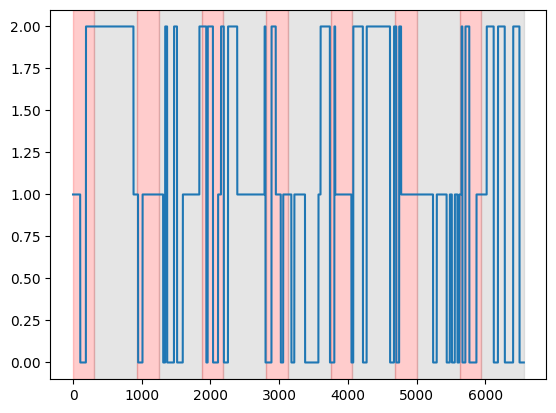

In [179]:
plot(preds,7)

In [181]:
print(model.transmat_)

[[0.98394753 0.00567937 0.01037311]
 [0.00545497 0.99230431 0.00224072]
 [0.00842104 0.00183731 0.98974164]]


In [185]:
model = hmm.GaussianHMM(n_components=4, n_iter=1000, verbose=True, tol=0.1)
model.fit(bands_z.T[0:500000])
preds= model.predict(bands_z.T[0:500000])

         1 -11014752.08921793             +nan
         2 -10457814.18212113 +556937.90709680
         3 -10368786.76211100  +89027.42001013
         4 -10347159.71786262  +21627.04424838
         5 -10332558.07376629  +14601.64409633
         6 -10317946.46343780  +14611.61032850
         7 -10299695.93081489  +18250.53262291
         8 -10265292.37915801  +34403.55165688
         9 -10194290.73642498  +71001.64273302
        10 -10124973.23239777  +69317.50402721
        11 -10096589.24914301  +28383.98325476
        12 -10084290.37708569  +12298.87205732
        13 -10074358.03844470   +9932.33864099
        14 -10065804.22809893   +8553.81034577
        15 -10059562.05984495   +6242.16825397
        16 -10055225.59912996   +4336.46071499
        17 -10052287.46692007   +2938.13220990
        18 -10050334.21513355   +1953.25178652
        19 -10048864.70520588   +1469.50992768
        20 -10047780.25874922   +1084.44645666
        21 -10046991.56462368    +788.69412554
        22 -1

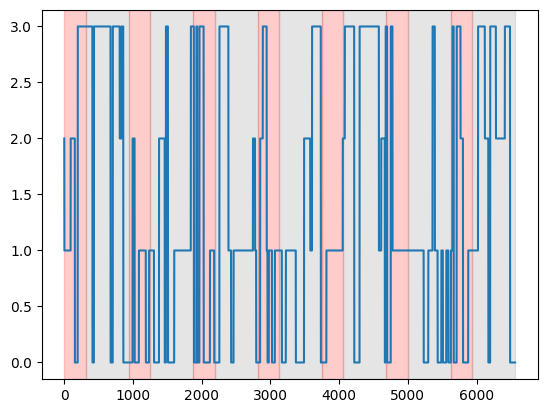

In [186]:
plot(preds,7)